In [1]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.optimizers import Adam 
#from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras import metrics

from sklearn.utils import shuffle

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import datetime as dt


Using TensorFlow backend.


In [2]:
# Import whole N-MNIST Dataset
def load_NMNIST(path):
    """
    """
    xs_train = []
    ys_train = []
    xs_test = []
    ys_test = []

    for class_index in range(0, 10):
        for (root, dirs, dat_files) in os.walk('{0}/n_Train_3/{1}'.format(path, str(class_index))):
            for file in dat_files:
                single_X = np.fromfile('{0}/n_Train_3/{1}/{2}'.format(path, str(class_index), file), dtype=np.int32)
                xs_train.append(single_X)
                ys_train.append(class_index)

        for (root, dirs, dat_files) in os.walk('{0}/n_Test_3/{1}'.format(path, str(class_index))):
            for file in dat_files:
                xs_test.append(np.fromfile('{0}/n_Test_3/{1}/{2}'.format(path, str(class_index), file), dtype=np.int32))
                ys_test.append(class_index)

    Xtr = np.array(xs_train)
    Ytr = np.array(ys_train)
    Xte = np.array(xs_test)
    Yte = np.array(ys_test)

    return Xtr, Ytr, Xte, Yte

In [3]:
dataset_class_path = 'C:/Users/Justin/Documents/LowPowerActionRecognition/CNN/NMNIST/datasets'
x_train_1, y_train, x_test_1, y_test = load_NMNIST(dataset_class_path)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', x_train_1.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', x_test_1.shape)
print('Test labels shape: ', y_test.shape)

# 34 x 34 x 2

Training data shape:  (60000, 2312)
Training labels shape:  (60000,)
Test data shape:  (10000, 2312)
Test labels shape:  (10000,)


In [4]:
# Test to see the maxima and minima of the dataset to flatten it
maxi = x_train_1[0][0]
mini = x_train_1[0][0]
for i in range (0, len(x_train_1)):
    if (max(x_train_1[i])>maxi):
        maxi = max(x_train_1[i])
    if (min(x_train_1[i])<mini):
        mini = min(x_train_1[i])
print(maxi)
print(mini)

13
-15


In [5]:
arr = np.array([1, 2, 0])
arr = arr.astype('float')
arr[arr == 0] = 'nan' # or use np.nan
print(arr)
arr2 = (arr/30)
print(arr2)
arr2[np.isnan(arr2)] = 0
#arr[arr == 'nan'] = 0 # or use np.nan
print(arr2)

[ 1.  2. nan]
[0.03333333 0.06666667        nan]
[0.03333333 0.06666667 0.        ]


In [6]:
# Flatten the dataset from range -1 to 1. Since the maxima and minima lies btw 15 so we divide it by 15.
x_train = x_train_1.astype('float32')
x_test = x_test_1.astype('float32')

In [7]:
x_train[x_train!=0]+= 30
x_test[x_test!=0]+= 30

x_train[:] = [x/45 for x in x_train]
x_test[:] = [x/45 for x in x_test]

In [8]:
def plot_autoencoder_outputs(encoder, n, dims):
    #decoded_imgs = enconder.predict(x_test)
    x_test_encoded = vae.predict(x_test, batch_size = batch_size)
    # number of example digits to show
    n = 5
    plt.figure(figsize=(20, 9))
    for i in range(n):
        # plot original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(*dims))
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')

        # plot reconstruction 
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(x_test_encoded[i].reshape(*dims))
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Reconstructed Images')
    plt.show()

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()

In [9]:
"""x_train[x_train>0]=1
x_train[x_train<0]=-1
x_test[x_test>0]=1
x_test[x_test<0]=-1
#print(x_train.shape)
print(np.max(x_train[0]))"""

'x_train[x_train>0]=1\nx_train[x_train<0]=-1\nx_test[x_test>0]=1\nx_test[x_test<0]=-1\n#print(x_train.shape)\nprint(np.max(x_train[0]))'

In [10]:
epsilon_std = 0.001

# z = z_mean + sqrt(var)*eps
#returns random value of z with the gives mean and variance
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.0, stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma/2) * epsilon

In [11]:
# network parameters
#batch_size - number of training examples 
#that are used at the same time to train the NN
#latent_dim - defines the dimentionality of the latent space
#2D latent space in this case
input_shape = (2312, )
intermediate_dim_1 = 64 # 64
intermediate_dim_2 = 32 # 32
intermediate_dim_3 = 16 # 16
intermediate_dim_4 = 8 # 16
intermediate_dim_5 = 8
batch_size = 80
latent_dim = 2
epochs = 20

In [12]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input') #2312
x = Dense(intermediate_dim_1, activation='relu')(inputs)
x = Dense(intermediate_dim_2, activation='relu')(x)
x = Dense(intermediate_dim_3, activation='relu')(x)
x = Dense(intermediate_dim_4, activation='relu')(x)
#x = Dense(intermediate_dim_5, activation='tanh')(x)
# x = Dense(intermediate_dim_2, activation='relu')(inputs)
# x = Dense(intermediate_dim_3, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [13]:
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 2312)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           148032      encoder_input[0][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 32)           2080        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 16)           528         dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

In [14]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
#x = Dense(intermediate_dim_5, activation='tanh')(latent_inputs)
x = Dense(intermediate_dim_4, activation='relu')(latent_inputs)
x = Dense(intermediate_dim_3, activation='relu')(x)
x = Dense(intermediate_dim_2, activation='relu')(x)
x = Dense(intermediate_dim_1, activation='relu')(x)
# x = Dense(intermediate_dim_3, activation='relu')(latent_inputs)
# x = Dense(intermediate_dim_2, activation='relu')(x)
outputs = Dense(2312, activation='sigmoid')(x)

In [15]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 24        
_________________________________________________________________
dense_6 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_7 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_9 (Dense)              (None, 2312)              150280    
Total params: 153,104
Trainable params: 153,104
Non-trainable params: 0
_________________________________________________________________


In [16]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')
vae_test=Model(inputs, outputs, name='vae_test')

In [17]:
# Compute VAE loss
xent_loss = 2312 * binary_crossentropy(inputs, outputs)
#xent_loss = binary_crossentropy(inputs, outputs)

kl_loss = -0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss =abs(K.mean(xent_loss + kl_loss))
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999)


vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae_test.compile(optimizer=opt, loss='binary_crossentropy', metrics=[metrics.categorical_accuracy, 'acc'])
vae.summary()
vae_test.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 2312)              0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 150812    
_________________________________________________________________
decoder (Model)              (None, 2312)              153104    
Total params: 303,916
Trainable params: 303,916
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 2312)              0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 150812    
_________________________________________________________________
deco

The loss function taking into account 2 factors, kl_loss and 

In [18]:
start_time = dt.datetime.now()
print('Start learning at {}'.format(str(start_time)))

# changes to epochs, validation_split and batch_size
vae.fit(x_train,    
        shuffle = True,
        epochs= epochs,
        validation_split= 0.2,
        batch_size= batch_size,
        )

end_time = dt.datetime.now() 
print('Stop learning {}'.format(str(end_time)))
elapsed_time= end_time - start_time
print('Elapsed learning {}'.format(str(elapsed_time)))

Start learning at 2019-01-23 14:22:35.951522
Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 10s 218us/step - loss: 408.1933 - val_loss: 351.2353
Epoch 2/20
48000/48000 [==============================] - 9s 193us/step - loss: 354.9962 - val_loss: 349.4082
Epoch 3/20
48000/48000 [==============================] - 9s 197us/step - loss: 349.7050 - val_loss: 340.3846
Epoch 4/20
48000/48000 [==============================] - 9s 188us/step - loss: 342.9782 - val_loss: 340.0466
Epoch 5/20
48000/48000 [==============================] - 9s 194us/step - loss: 340.7156 - val_loss: 339.1982
Epoch 6/20
48000/48000 [==============================] - 9s 189us/step - loss: 339.4185 - val_loss: 338.5545
Epoch 7/20
48000/48000 [==============================] - 9s 197us/step - loss: 338.2034 - val_loss: 338.1404
Epoch 8/20
48000/48000 [==============================] - 9s 196us/step - loss: 337.4722 - val_loss: 338.7416
Epoch 9/20
48000/48000 [

In [19]:
models = (encoder, decoder)
data = (x_test, y_test)

In [20]:
def plot_results(models,
                 data,
                 batch_size=100,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    print(z_mean)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]
    


[[ 0.00817619  0.4511245 ]
 [ 0.09034985  0.5240276 ]
 [ 0.10676719  0.56359255]
 ...
 [-0.11580412 -0.13984735]
 [ 0.03400047 -0.1483433 ]
 [-0.01629275 -0.02468408]]


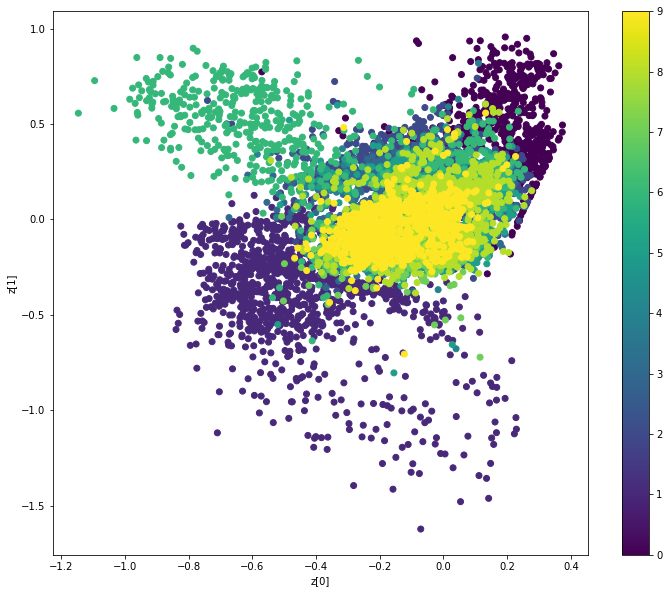

In [21]:
plot_results(models,
                 data,
                 batch_size=batch_size,
                 model_name="vae_mlp")

In [22]:
x_test_encoded = vae.predict(x_test, batch_size = batch_size)

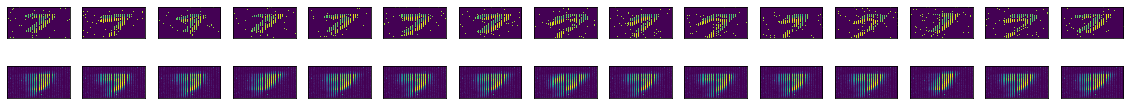

In [23]:
n = 15
plt.figure(figsize=(20, 2))
j=8000
for i in range(n):
    # plot original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[j].reshape(34, 68))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Original Images')

    # plot noisy image 
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_encoded[j].reshape(34, 68))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Noisy Input')
    j = j+1

In [24]:
#plot_autoencoder_outputs(x_test, 5, (34, 68))

In [25]:
vae_test.set_weights(vae.get_weights())

from random import shuffle

# shuffle(x_test)

score = vae_test.evaluate(x_test, x_test, verbose=1, batch_size=80)
#score = vae.evaluate(x_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 1s 113us/step
Test loss: 0.14092852169275283
Test accuracy: 0.028000000402331353


Add a pre_train SVM model after the decoder then compare it with a normal SVM